Trajectory Smoothing Strategy Optimization System
Loading data...
Successfully loaded saved trajectory data: ./trajectory_id_323.csv
Data source: saved
Trajectory data shape: (377, 13)
Trajectory time span: 15.04 seconds

Processing trajectory data...
Plotting trajectory comparison...


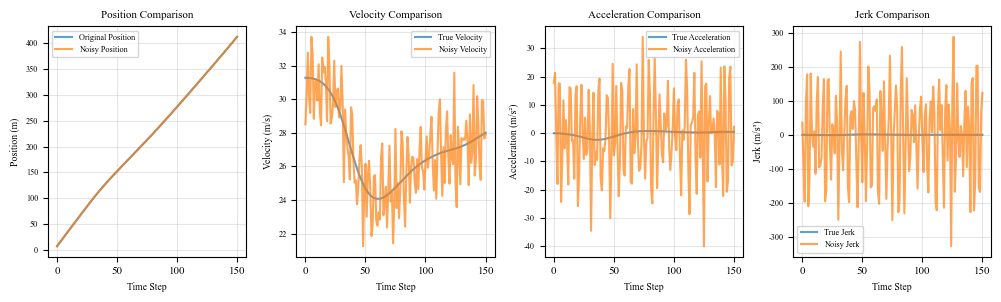

Performing parameter optimization...
Optimal parameters found: [7.6]
Plotting optimization results...


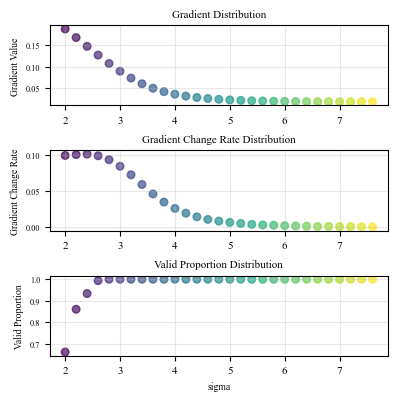

Plotting smoothing effect comparison...


C:\Users\13968\AppData\Local\Temp\ipykernel_32972\2217151155.py:649: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


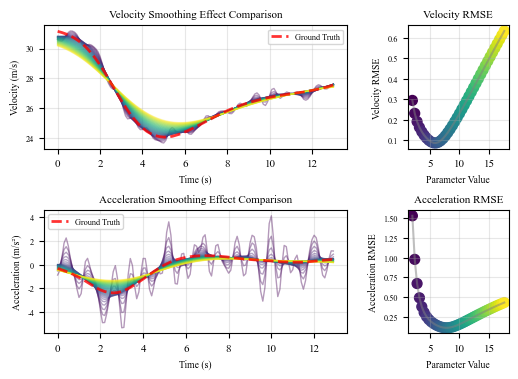


Optimization Results:
Optimal parameters: [7.6]
Data source: saved
Processing completed


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from scipy.signal import savgol_filter, butter, filtfilt
from scipy.ndimage import gaussian_filter, uniform_filter1d
# from scipy.interpolate import UnivariateSpline
# from filterpy.kalman import KalmanFilter
import os
from pathlib import Path

# Set font for English display
plt.rcParams['font.family'] = ['Times New Roman', 'Arial']
plt.rcParams['axes.unicode_minus'] = False

def create_sample_data():
    """Create sample trajectory data"""
    np.random.seed(42)
    
    # Generate time series
    time_steps = 200
    t = np.linspace(0, 8, time_steps)
    
    # Generate simulated trajectory (including acceleration, constant speed, deceleration phases)
    x = np.zeros_like(t)
    velocity = np.zeros_like(t)
    acceleration = np.zeros_like(t)
    
    # Generate trajectory by segments
    for i in range(1, len(t)):
        if i < 50:  # Acceleration phase
            acceleration[i] = 2.0 + 0.5 * np.sin(0.1 * i)
        elif i < 100:  # Constant speed phase
            acceleration[i] = 0.1 * np.sin(0.1 * i)
        elif i < 150:  # Deceleration phase
            acceleration[i] = -1.5 + 0.3 * np.sin(0.1 * i)
        else:  # Re-acceleration phase
            acceleration[i] = 1.0 + 0.4 * np.sin(0.1 * i)
        
        velocity[i] = velocity[i-1] + acceleration[i] * (t[i] - t[i-1])
        x[i] = x[i-1] + velocity[i] * (t[i] - t[i-1])
    
    # Create DataFrame
    df = pd.DataFrame({
        'frame': np.arange(len(t)),
        'id': [323] * len(t),
        'x': x,
        'y': np.ones_like(x) * 100,  # Fixed y coordinate
        'width': np.ones_like(x) * 4,
        'height': np.ones_like(x) * 2,
        'xVelocity': velocity,
        'yVelocity': np.zeros_like(velocity),
        'xAcceleration': acceleration,
        'yAcceleration': np.zeros_like(acceleration),
        'laneId': [5] * len(t)
    })
    
    return df

def load_highd_data(data_path, num_files=3, target_lanes=[5, 6], acceleration_threshold=2):
    """
    Load HighD dataset
    
    Parameters:
    - data_path: HighD data file path
    - num_files: Number of files to load
    - target_lanes: Target lane ID list
    - acceleration_threshold: Acceleration threshold
    
    Returns:
    - df_total: Combined dataframe
    - high_acceleration_ids: High acceleration vehicle ID list
    """
    
    if not os.path.exists(data_path):
        print(f"Warning: HighD data path {data_path} does not exist")
        return None, []
    
    totalidlen = 0
    df_total = pd.DataFrame()
    
    print(f"Loading HighD data...")
    
    for i in range(num_files):
        file_path = os.path.join(data_path, f'{str(i+1).zfill(2)}_tracks.csv')
        
        if not os.path.exists(file_path):
            print(f"Warning: File {file_path} does not exist, skipping")
            continue
            
        try:
            df2 = pd.read_csv(file_path)
            print(f"Successfully loaded file {i+1:02d}")
            
            # Update ID to avoid duplicates
            dfidlen = len(df2.id.unique())
            df2.id = df2.id + totalidlen
            
            # Calculate time duration
            dfframelen = df2.frame.max() - df2.frame.min()
            print(f'File {i+1:02d} duration: {dfframelen//25}s ({dfframelen//25//60}min)')
            
            # Avoid spatiotemporal conflicts
            df2.frame = df2.frame + 20*60*25*i
            
            df_total = pd.concat([df_total, df2], ignore_index=True)
            totalidlen += dfidlen
            
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            continue
    
    if df_total.empty:
        print("Failed to load any HighD data")
        return None, []
    
    # Select required columns
    df_total = df_total[['frame', 'id', 'x', 'y', 'width', 'height', 
                        'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration', 'laneId']]
    
    # Select target lanes
    df_total = df_total[df_total['laneId'].isin(target_lanes)]
    
    # Find high acceleration vehicles
    high_acceleration_ids = df_total[df_total['xAcceleration'].abs() > acceleration_threshold]['id'].unique().tolist()
    
    print(f"Data loading completed:")
    print(f"- Total trajectory points: {len(df_total)}")
    print(f"- Number of vehicles: {len(df_total.id.unique())}")
    print(f"- High acceleration vehicles: {len(high_acceleration_ids)}")
    print(f"- High acceleration vehicle IDs: {high_acceleration_ids[:10]}{'...' if len(high_acceleration_ids) > 10 else ''}")
    
    return df_total, high_acceleration_ids

def extract_and_save_trajectory(df_total, vehicle_id=323, save_path='./'):
    """
    Extract specific vehicle trajectory and save
    
    Parameters:
    - df_total: Total dataframe
    - vehicle_id: Vehicle ID
    - save_path: Save path
    
    Returns:
    - trajectory: Extracted trajectory data
    """
    
    if df_total is None or df_total.empty:
        print("Data is empty, cannot extract trajectory")
        return None
    
    # Extract specific vehicle trajectory
    trajectory = df_total[df_total['id'] == vehicle_id].copy()
    
    if trajectory.empty:
        print(f"No trajectory data found for vehicle ID {vehicle_id}")
        return None
    
    # Add time column
    sampling_frequency = 25
    time_interval = 1 / sampling_frequency
    trajectory['t'] = np.arange(len(trajectory)) * time_interval
    trajectory['t1'] = trajectory['t']
    
    # Save trajectory data
    save_file = os.path.join(save_path, f'trajectory_id_{vehicle_id}.csv')
    trajectory.to_csv(save_file, index=False)
    
    print(f"Trajectory for vehicle ID {vehicle_id} saved to: {save_file}")
    print(f"Trajectory length: {len(trajectory)} data points")
    print(f"Time span: {trajectory['t'].max():.2f} seconds")
    
    return trajectory

def load_or_create_data(highd_path=None, use_sample=True, vehicle_id=323):
    """
    Load or create trajectory data
    
    Parameters:
    - highd_path: HighD data path
    - use_sample: Whether to use sample data
    - vehicle_id: Target vehicle ID
    
    Returns:
    - trajectory: Trajectory data
    - data_source: Data source identifier
    """
    
    trajectory = None
    data_source = "sample"
    
    # First try to load saved trajectory
    saved_trajectory_path = f'./trajectory_id_{vehicle_id}.csv'
    if os.path.exists(saved_trajectory_path):
        try:
            trajectory = pd.read_csv(saved_trajectory_path)
            print(f"Successfully loaded saved trajectory data: {saved_trajectory_path}")
            data_source = "saved"
            return trajectory, data_source
        except Exception as e:
            print(f"Failed to load saved trajectory: {e}")
    
    # If not using sample data and HighD path provided, try to load HighD data
    if not use_sample and highd_path:
        df_total, high_acceleration_ids = load_highd_data(highd_path)
        
        if df_total is not None and not df_total.empty:
            # Check if target vehicle exists
            if vehicle_id in df_total['id'].unique():
                trajectory = extract_and_save_trajectory(df_total, vehicle_id)
                data_source = "highd"
            else:
                print(f"Vehicle ID {vehicle_id} not found in HighD data")
                print(f"Available high acceleration vehicle IDs: {high_acceleration_ids[:10]}")
                
                if high_acceleration_ids:
                    # Use first high acceleration vehicle
                    alternative_id = high_acceleration_ids[0]
                    print(f"Using alternative vehicle ID: {alternative_id}")
                    trajectory = extract_and_save_trajectory(df_total, alternative_id)
                    data_source = "highd"
    
    # If still no data, use sample data
    if trajectory is None:
        print("Using sample data...")
        trajectory = create_sample_data()
        trajectory.to_csv(f'./sample_trajectory_id_{vehicle_id}.csv', index=False)
        print(f"Sample data saved to: ./sample_trajectory_id_{vehicle_id}.csv")
        data_source = "sample"
    
    return trajectory, data_source

class TrajectoryProcessor:
    """Trajectory data processing and smoothing strategy optimization class"""
    
    def __init__(self, sampling_frequency=25, target_frequency=10):
        self.sampling_frequency = sampling_frequency
        self.target_frequency = target_frequency
        self.time_window = 10
        
    def add_noise(self, df, noise_std, seed=42):
        """Add Gaussian noise to trajectory data"""
        np.random.seed(seed)
        df_noisy = df.copy()
        noise = np.random.normal(0, noise_std, len(df))
        df_noisy['n_x'] = df_noisy['x'] + noise
        return df_noisy
    
    def downsample_trajectory(self, df, target_interval='100ms'):
        """Downsample trajectory"""
        df_copy = df.copy()
        df_copy['time'] = pd.to_datetime(df_copy['t'], unit='s')
        df_copy = df_copy.set_index('time')
        resampled = df_copy.resample(target_interval).interpolate(method='linear')
        return resampled.reset_index(drop=True)
    
    def calculate_velocity(self, positions, dt=0.1):
        """Calculate velocity"""
        velocity = np.gradient(positions, dt)
        return velocity
    
    def calculate_acceleration(self, velocity, dt=0.1):
        """Calculate acceleration"""
        acceleration = np.gradient(velocity, dt)
        return acceleration
    
    def process_trajectory(self, df, noise_std=0.25, seed=42):
        """Complete trajectory processing pipeline"""
        # Ensure time column exists
        if 't' not in df.columns:
            df['t'] = np.arange(len(df)) / self.sampling_frequency
        
        # Downsample
        df_processed = self.downsample_trajectory(df)
        
        # Add noise
        df_processed = self.add_noise(df_processed, noise_std, seed)
        
        # Calculate ground truth values
        df_processed['true_velocity'] = df_processed['xVelocity']
        df_processed['true_acceleration'] = df_processed['xAcceleration']
        
        # Calculate velocity and acceleration after noise
        df_processed['noisy_velocity'] = self.calculate_velocity(df_processed['n_x'])
        df_processed['noisy_acceleration'] = self.calculate_acceleration(df_processed['noisy_velocity'])
        
        return df_processed

class SmoothingMethods:
    """Implementation of various smoothing methods"""
    
    # @staticmethod
    # def moving_average(data, window_size):
    #     """Moving average filter"""
    #     if isinstance(data, pd.Series):
    #         return data.rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    #     else:
    #         return pd.Series(data).rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill').values
    
    # @staticmethod
    # def savgol_filter_method(data, window_size, poly_order=2):
    #     """Savitzky-Golay filter"""
    #     if isinstance(data, pd.Series):
    #         return savgol_filter(data.values, window_size, poly_order)
    #     else:
    #         return savgol_filter(data, window_size, poly_order)
    
    # @staticmethod
    # def butterworth_filter(data, cutoff_freq, sampling_rate=10, order=2):
    #     """Butterworth filter"""
    #     nyquist_freq = 0.5 * sampling_rate
    #     normal_cutoff = cutoff_freq / nyquist_freq
    #     b, a = butter(order, normal_cutoff, btype='low', analog=False)
        
    #     if isinstance(data, pd.Series):
    #         return filtfilt(b, a, data.values)
    #     else:
    #         return filtfilt(b, a, data)
    
    @staticmethod
    def gaussian_filter_method(data, sigma):
        """Gaussian filter"""
        if isinstance(data, pd.Series):
            return gaussian_filter(data.values, sigma=sigma)
        else:
            return gaussian_filter(data, sigma=sigma)
    
    # @staticmethod
    # def bspline_filter(data, s=1.0):
    #     """B-spline smoothing"""
    #     if isinstance(data, pd.Series):
    #         data_values = data.values
    #     else:
    #         data_values = data
            
    #     x = np.arange(len(data_values))
    #     spline = UnivariateSpline(x, data_values, s=s)
    #     return spline(x)
    
    # @staticmethod
    # def kalman_filter_method(data, process_noise_std=0.1, measurement_noise_std=1.0):
    #     """Kalman filter"""
    #     if isinstance(data, pd.Series):
    #         data_values = data.values
    #         first_value = data.iloc[0]
    #     else:
    #         data_values = data
    #         first_value = data[0]
            
    #     kf = KalmanFilter(dim_x=2, dim_z=1)
    #     kf.x = np.array([first_value, 0])
    #     kf.F = np.array([[1, 1], [0, 1]])
    #     kf.H = np.array([[1, 0]])
    #     kf.P *= 10
    #     kf.R = np.eye(1) * measurement_noise_std ** 2
    #     kf.Q = np.eye(2) * process_noise_std ** 2
        
    #     smoothed_data = []
    #     for i in range(len(data_values)):
    #         kf.predict()
    #         kf.update(np.array([data_values[i]]))
    #         smoothed_data.append(kf.x[0])
    #     return np.array(smoothed_data)

class OptimizationEngine:
    """Smoothing parameter optimization engine"""
    
    def __init__(self, time_window=10, target_frequency=10):
        self.time_window = time_window
        self.target_frequency = target_frequency
    
    def calculate_local_variance(self, velocity):
        """Calculate local variance"""
        acceleration = np.gradient(velocity, 1/self.target_frequency)
        acceleration_mean = uniform_filter1d(acceleration, size=2*self.time_window, 
                                           mode='reflect', origin=-self.time_window)
        acceleration_variance = np.sqrt(
            uniform_filter1d(acceleration**2, size=2*self.time_window, 
                           mode='reflect', origin=-self.time_window) - acceleration_mean**2
        )
        
        # Extract valid portion
        valid_start = self.time_window
        valid_end = len(acceleration) - self.time_window + 1
        return acceleration_variance[valid_start:valid_end], acceleration_mean[valid_start:valid_end]
    
    def calculate_stability(self, acceleration_variance, acceleration_mean, method='weighted'):
        """Calculate stability metric"""
        if method == 'median':
            return np.median(acceleration_variance)
        elif method == 'mean':
            return np.mean(acceleration_variance)
        elif method == 'weighted':
            weights = np.abs(acceleration_mean)
            if np.sum(weights) > 0:
                weights /= np.sum(weights)
                return np.sum(acceleration_variance * weights)
            else:
                return np.mean(acceleration_variance)
    
    def calculate_valid_proportion(self, data, smoothing_func, params, threshold=10):
        """Calculate valid proportion (proportion of acceleration and jerk within reasonable range)"""
        smoothed_velocity = smoothing_func(data['noisy_velocity'], *params)
        smoothed_acceleration = self.calculate_acceleration(smoothed_velocity)
        smoothed_jerk = self.calculate_acceleration(smoothed_acceleration)
        
        valid_mask = ((np.abs(smoothed_acceleration) <= threshold) & 
                     (np.abs(smoothed_jerk) <= threshold))
        return valid_mask.mean()
    
    def calculate_acceleration(self, velocity):
        """Calculate acceleration"""
        return np.gradient(velocity, 1/self.target_frequency)
    
    def calculate_gradient(self, data, smoothing_func, params, deltas, stability_method='weighted'):
        """Calculate gradient"""
        base_stability = self.calculate_stability(
            *self.calculate_local_variance(smoothing_func(data['noisy_velocity'], *params)),
            method=stability_method
        )
        
        gradients = []
        for i, delta in enumerate(deltas):
            params_delta = params.copy()
            params_delta[i] += delta
            
            stability_delta = self.calculate_stability(
                *self.calculate_local_variance(smoothing_func(data['noisy_velocity'], *params_delta)),
                method=stability_method
            )
            
            if base_stability > 0:
                gradient = (base_stability - stability_delta) / base_stability
            else:
                gradient = 0
            gradients.append(gradient)
        
        return np.array(gradients)
    
    def optimize_parameters(self, data, smoothing_func, param_ranges, deltas, 
                          stability_method='weighted', convergence_threshold=0.003):
        """Optimize smoothing parameters"""
        param_grid = np.meshgrid(*param_ranges)
        param_grid = np.array(param_grid).T.reshape(-1, len(param_ranges))
        
        results = {
            'param_values': [],
            'gradients': [],
            'proportions': [],
            'optimal_param': None
        }
        
        for i, params in enumerate(param_grid):
            # Calculate gradient
            gradient = self.calculate_gradient(data, smoothing_func, params, deltas, stability_method)
            
            # Calculate valid proportion
            proportion = self.calculate_valid_proportion(data, smoothing_func, params)
            
            results['param_values'].append(params)
            results['gradients'].append(gradient)
            results['proportions'].append(proportion)
            
            # Check convergence criteria
            if i > 0 and proportion >= 0.99:
                grad_change = np.abs(results['gradients'][-1] - results['gradients'][-2]) /results['gradients'][-1]
                if np.all(grad_change < convergence_threshold):
                    results['optimal_param'] = params
                    print(f"Optimal parameters found: {params}")
                    break
        
        return results

class Visualizer:
    """Visualization utility class"""
    
    def __init__(self):
        self.setup_plot_style()
    
    def setup_plot_style(self):
        """Setup plot style"""
        plt.rcParams.update({
            'font.size': 6,
            'axes.titlesize': 8,
            'axes.labelsize': 7,
            'xtick.labelsize': 8,
            'ytick.labelsize': 6,
            'legend.fontsize': 6,
            'figure.titlesize': 6,
        })
    
    def plot_trajectory_comparison(self, df):
        """Plot trajectory comparison"""
        fig, axes = plt.subplots(1, 4, figsize=(10, 3))
        
        # Position comparison
        axes[0].plot(df['x'], label='Original Position', alpha=0.7)
        axes[0].plot(df['n_x'], label='Noisy Position', alpha=0.7)
        axes[0].set_title('Position Comparison')
        axes[0].set_xlabel('Time Step')
        axes[0].set_ylabel('Position (m)')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Velocity comparison
        axes[1].plot(df['true_velocity'], label='True Velocity', alpha=0.7)
        axes[1].plot(df['noisy_velocity'], label='Noisy Velocity', alpha=0.7)
        axes[1].set_title('Velocity Comparison')
        axes[1].set_xlabel('Time Step')
        axes[1].set_ylabel('Velocity (m/s)')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Acceleration comparison
        axes[2].plot(df['true_acceleration'], label='True Acceleration', alpha=0.7)
        axes[2].plot(df['noisy_acceleration'], label='Noisy Acceleration', alpha=0.7)
        axes[2].set_title('Acceleration Comparison')
        axes[2].set_xlabel('Time Step')
        axes[2].set_ylabel('Acceleration (m/s²)')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Jerk comparison
        true_jerk = np.gradient(df['true_acceleration'], 1/10)
        noisy_jerk = np.gradient(df['noisy_acceleration'], 1/10)
        axes[3].plot(true_jerk, label='True Jerk', alpha=0.7)
        axes[3].plot(noisy_jerk, label='Noisy Jerk', alpha=0.7)
        axes[3].set_title('Jerk Comparison')
        axes[3].set_xlabel('Time Step')
        axes[3].set_ylabel('Jerk (m/s³)')
        axes[3].legend()
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def plot_optimization_results(self, results, param_names):
        """Plot optimization results"""
        param_values = np.array(results['param_values'])
        gradients = np.array(results['gradients'])
        proportions = np.array(results['proportions'])
        
        if param_values.shape[1] == 1:
            fig, axes = plt.subplots(3, 1, figsize=(4, 4))
            
            # Gradient distribution
            axes[0].scatter(param_values[:, 0], gradients[:, 0], 
                          c=param_values[:, 0], cmap='viridis', s=30, alpha=0.7)
            axes[0].set_ylabel('Gradient Value')
            axes[0].set_title('Gradient Distribution')
            axes[0].grid(True, alpha=0.3)
            
            # Gradient change rate
            gradient_change = -np.gradient(gradients[:, 0], param_values[:, 0])
            axes[1].scatter(param_values[:, 0], gradient_change, 
                          c=param_values[:, 0], cmap='viridis', s=30, alpha=0.7)
            axes[1].set_ylabel('Gradient Change Rate')
            axes[1].set_title('Gradient Change Rate Distribution')
            axes[1].grid(True, alpha=0.3)
            
            # Valid proportion
            axes[2].scatter(param_values[:, 0], proportions, 
                          c=param_values[:, 0], cmap='viridis', s=30, alpha=0.7)
            axes[2].set_xlabel(param_names[0])
            axes[2].set_ylabel('Valid Proportion')
            axes[2].set_title('Valid Proportion Distribution')
            axes[2].grid(True, alpha=0.3)
            
            plt.tight_layout()
            return fig
    
    def plot_smoothing_comparison(self, data, smoothing_func, param_list, time_window=10):
        """Plot smoothing effect comparison with different parameters"""
        fig = plt.figure(figsize=(6, 4))
        gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], hspace=0.5, wspace=0.3)
        
        ax1 = fig.add_subplot(gs[0, 0])  # Velocity comparison
        ax2 = fig.add_subplot(gs[1, 0])  # Acceleration comparison
        ax3 = fig.add_subplot(gs[0, 1])  # Velocity RMSE
        ax4 = fig.add_subplot(gs[1, 1])  # Acceleration RMSE
        
        # Prepare data
        true_velocity = data['true_velocity'][time_window:-time_window]
        true_acceleration = data['true_acceleration'][time_window:-time_window-1]
        time_axis = np.arange(len(true_velocity)) / 10
        
        # Color mapping
        param_values = [p[0] for p in param_list]
        cmap = plt.get_cmap('viridis')
        norm = plt.Normalize(vmin=min(param_values), vmax=max(param_values))
        
        rmse_velocity = []
        rmse_acceleration = []
        
        # Plot results with different parameters
        for param in param_list:
            color = cmap(norm(param[0]))
            
            # Apply smoothing
            smoothed_velocity = smoothing_func(data['noisy_velocity'], *param)
            smoothed_velocity = smoothed_velocity[time_window:-time_window]
            
            smoothed_acceleration = np.gradient(smoothed_velocity, 1/10)
            smoothed_acceleration = smoothed_acceleration[:-1]
            
            # Plot curves
            ax1.plot(time_axis, smoothed_velocity, color=color, alpha=0.4, linewidth=1)
            ax2.plot(time_axis[:-1], smoothed_acceleration, color=color, alpha=0.4, linewidth=1)
            
            # Calculate RMSE
            rmse_v = np.sqrt(np.mean((smoothed_velocity - true_velocity)**2))
            rmse_a = np.sqrt(np.mean((smoothed_acceleration - true_acceleration)**2))
            rmse_velocity.append(rmse_v)
            rmse_acceleration.append(rmse_a)
        
        # Plot ground truth
        ax1.plot(time_axis, true_velocity, 'r--', alpha=0.8, label='Ground Truth', linewidth=2)
        ax2.plot(time_axis[:-1], true_acceleration, 'r--', alpha=0.8, label='Ground Truth', linewidth=2)
        
        # Plot RMSE
        ax3.scatter(param_values, rmse_velocity, c=param_values, cmap=cmap, norm=norm, s=50)
        ax3.plot(param_values, rmse_velocity, color='gray', alpha=0.5)
        ax4.scatter(param_values, rmse_acceleration, c=param_values, cmap=cmap, norm=norm, s=50)
        ax4.plot(param_values, rmse_acceleration, color='gray', alpha=0.5)
        
        # Set labels and titles
        ax1.set_ylabel('Velocity (m/s)')
        ax1.set_xlabel('Time (s)')
        ax1.set_title('Velocity Smoothing Effect Comparison')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2.set_ylabel('Acceleration (m/s²)')
        ax2.set_xlabel('Time (s)')
        ax2.set_title('Acceleration Smoothing Effect Comparison')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        ax3.set_xlabel('Parameter Value')
        ax3.set_ylabel('Velocity RMSE')
        ax3.set_title('Velocity RMSE')
        ax3.grid(True, alpha=0.3)
        
        ax4.set_xlabel('Parameter Value')
        ax4.set_ylabel('Acceleration RMSE')
        ax4.set_title('Acceleration RMSE')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

def main():
    """Main function"""
    print("="*60)
    print("Trajectory Smoothing Strategy Optimization System")
    print("="*60)
    
    # Configuration parameters
    HIGHD_DATA_PATH = 'E:\\轨迹数据\\highd\\data\\'  # Modify to your HighD data path
    USE_SAMPLE_DATA = False  # Set to False to use HighD data
    TARGET_VEHICLE_ID = 323
    
    # Load data
    print("Loading data...")
    trajectory, data_source = load_or_create_data(
        highd_path=HIGHD_DATA_PATH if not USE_SAMPLE_DATA else None,
        use_sample=USE_SAMPLE_DATA,
        vehicle_id=TARGET_VEHICLE_ID
    )
    
    print(f"Data source: {data_source}")
    print(f"Trajectory data shape: {trajectory.shape}")
    print(f"Trajectory time span: {trajectory.get('t', pd.Series([0])).max():.2f} seconds")
    
    # Initialize processors
    processor = TrajectoryProcessor()
    optimizer = OptimizationEngine()
    visualizer = Visualizer()
    
    # Process trajectory data
    print("\nProcessing trajectory data...")
    processed_data = processor.process_trajectory(trajectory, noise_std=0.25)
    
    # Plot original comparison
    print("Plotting trajectory comparison...")
    fig1 = visualizer.plot_trajectory_comparison(processed_data)
    plt.show()
    
    # Parameter optimization
    print("Performing parameter optimization...")
    smoothing_func = SmoothingMethods.gaussian_filter_method
    param_ranges = [np.arange(2, 20, 0.2)]
    deltas = [0.2]
    param_names = ['sigma']
    
    results = optimizer.optimize_parameters(
        processed_data, 
        smoothing_func, 
        param_ranges, 
        deltas,
        stability_method='weighted'
    )
    
    # Plot optimization results
    print("Plotting optimization results...")
    fig2 = visualizer.plot_optimization_results(results, param_names)
    plt.show()
    
    # Plot smoothing effect comparison
    print("Plotting smoothing effect comparison...")
    param_list = [[i] for i in np.arange(2, 18, 0.4)]
    fig3 = visualizer.plot_smoothing_comparison(processed_data, smoothing_func, param_list)
    plt.show()
    
    # Output results
    print("\n" + "="*60)
    print("Optimization Results:")
    if results['optimal_param'] is not None:
        print(f"Optimal parameters: {results['optimal_param']}")
    else:
        print("No optimal parameters found, please adjust parameter range or convergence criteria")
    
    print(f"Data source: {data_source}")
    print(f"Processing completed")
    print("="*60)


if __name__ == "__main__":
    main()